**Remarks**

In this notebook, we will learn about twitter-news-vector using word2Vec. Yeayy! I will show to download kaggle into your notebook. Let's started!

In [62]:
# import library
# 1. dataframe environment
import numpy as np 
import pandas as pd
from sklearn.utils import resample
from sklearn.utils import shuffle

# 2. NLP tools
from string import punctuation
import pickle, re
from gensim.models.keyedvectors import KeyedVectors
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

# 3. Modelling tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 4. Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# preparing download dataset from Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d crowdflower/twitter-airline-sentiment
!kaggle datasets download -d sandreds/googlenewsvectorsnegative300

# NOTED: You must create kaggle api from your account

  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 82.0MB/s]
100% 1.63G/1.64G [00:27<00:00, 54.4MB/s]
100% 1.64G/1.64G [00:27<00:00, 64.9MB/s]


In [10]:
# unzipping dataset
!unzip "googlenewsvectorsnegative300.zip"
!unzip "twitter-airline-sentiment.zip"

Archive:  googlenewsvectorsnegative300.zip
  inflating: GoogleNews-vectors-negative300.bin  
Archive:  twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


**Talks about dataset**

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

In [11]:
# read dataset
data_tweet = pd.read_csv("Tweets.csv")
data_tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [12]:
# shape dataframe
print("Shape of Dataframe", data_tweet.shape)

Shape of Dataframe (14640, 15)


In [13]:
# sentiment counts
sentiment_counts = data_tweet.airline_sentiment.value_counts()
print(sentiment_counts)

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


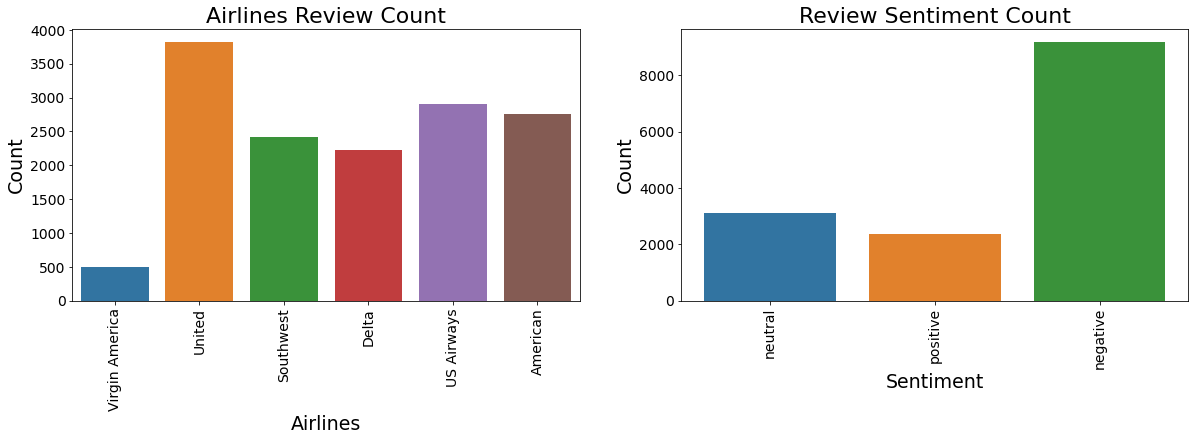

In [16]:
# visualization
figsize = (20,5)
ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize' : ticksize,
          'ytick.labelsize' : ticksize}
plt.rcParams.update(params)

plt.subplot(121)
col = 'airline'
xlabel = 'Airlines'
ylabel = 'Count'

sns.countplot(x=data_tweet[col])
plt.title("Airlines Review Count")
plt.xticks(rotation=90)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.subplot(122)
col = 'airline_sentiment'
xlabel = 'Sentiment'
ylabel = 'Count'

sns.countplot(x=data_tweet[col])
plt.title("Review Sentiment Count")
plt.xticks(rotation=90)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.plot()
plt.show();

Based on information above, United is highest number of tweets, but Virgin not. We found many bad experience in tweet about American Airlines. Let's we view sentiment on every airlines , check it out! What they talking about

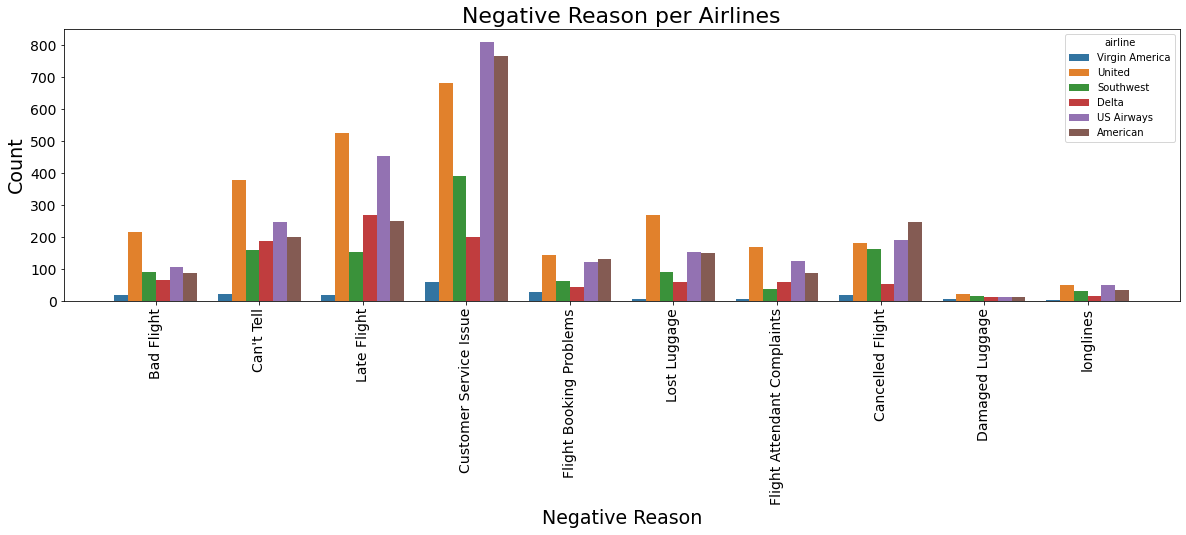

In [18]:
figsize=(20,5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

xlabel = "Negative Reason"
ylabel = "Count"
title = "Negative Reason per Airlines"

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize' : ticksize,
          'ytick.labelsize' : ticksize}
plt.rcParams.update(params)

col1 = "negativereason"
col2 = "airline"
sns.countplot(x=data_tweet[col1], hue=data_tweet[col2])
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.plot();

Majority problem is customer service issue. So every airplanes must consider about service quality (Can check using quantitative, like my research before: [Click here!](https://scholar.google.co.id/citations?view_op=view_citation&hl=en&user=fELMVS4AAAAJ&citation_for_view=fELMVS4AAAAJ:u-x6o8ySG0sC))

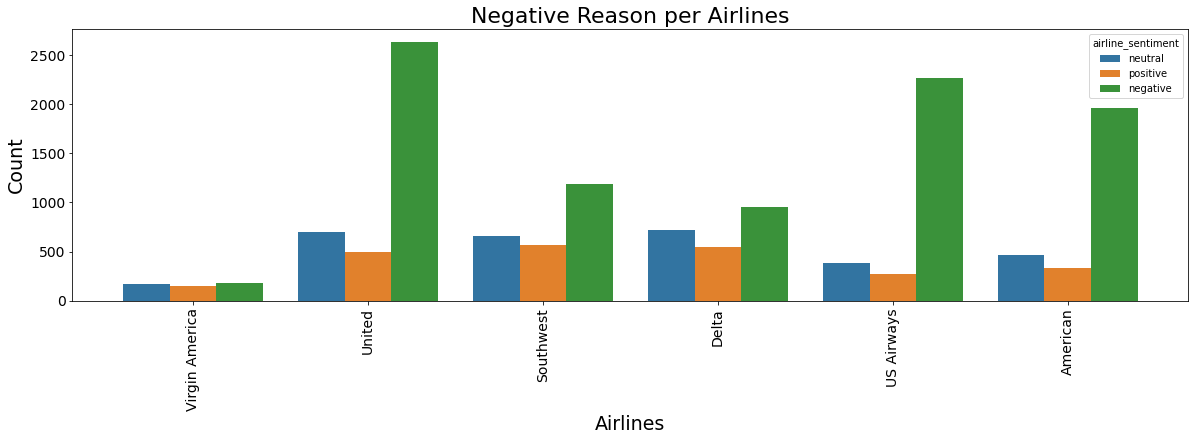

In [19]:
figsize=(20,5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

xlabel = "Airlines"
ylabel = "Count"

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize' : ticksize,
          'ytick.labelsize' : ticksize}
plt.rcParams.update(params)

plt.figure(figsize=figsize)
col1 = "airline"
col2 = "airline_sentiment"
sns.countplot(x=data_tweet[col1], hue=data_tweet[col2])
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.plot();

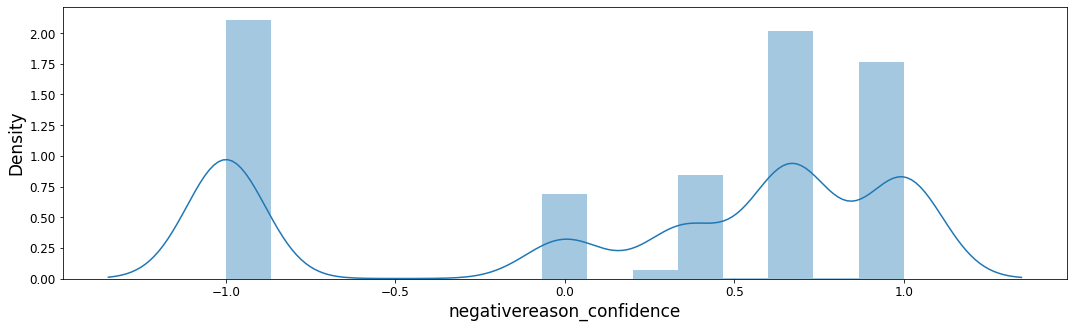

In [21]:
# checking distribution of data sentiment
# It's useful for stabilization distribution
x = data_tweet['negativereason_confidence'].fillna(-1)
figsize=(18,5)

ticksize = 12
titlesize = ticksize + 8
labelsize = ticksize + 5

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize' : ticksize,
          'ytick.labelsize' : ticksize}
plt.rcParams.update(params)

sns.distplot(x)
plt.plot();

In [27]:
# OVERSAMPLING - upper data adding
df_class_neg = data_tweet[data_tweet['airline_sentiment'] == 'negative']
df_class_pov = data_tweet[data_tweet['airline_sentiment'] == 'positive']
df_class_net = data_tweet[data_tweet['airline_sentiment'] == 'neutral']

target_count = data_tweet.airline_sentiment.value_counts()

# Resampling to negative* highest counting
print("Number negative: {},\nNumber positive: {},\nNumber Neutral: {}".format(target_count[0], target_count[1], target_count[2]))
df_class_pov = df_class_pov.sample(target_count[0], replace=True)
df_class_net = df_class_net.sample(target_count[0], replace=True)

df_test_over_total = pd.concat([df_class_neg, df_class_pov,
                                df_class_net], axis=0)
print("\nAfter resampling:\n{}".format(df_test_over_total.airline_sentiment.value_counts()))

Number negative: 9178,
Number positive: 3099,
Number Neutral: 2363

After resampling:
positive    9178
neutral     9178
negative    9178
Name: airline_sentiment, dtype: int64


In [63]:
# Implementating word2vec
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
word_vectors = model.wv

In [60]:
# function preparation
def sentenceEmbedding(tokens):
  vectors=[]
  for word in tokens:
    if word not in word_vectors.vocab:
      vectors.append([0]*300) #size of feature vector
    else:
      vectors.append(model[word])
  result=[0] * len(vectors[0])
  res=0
  for i in range(len(vectors[0])):
    for vec in vectors:
      res+=vec[i]
    result[i]=(res/(len(tokens)))
    res=0
         
  return result

# Labeling
def mapSentiment(airlineSentiment):
  if airlineSentiment == 'positive':
    return 1
  elif airlineSentiment == 'negative':
    return 0
  else:
    return 2

wordnet_lemmatizer = WordNetLemmatizer()
# Cleaning
def cleanString(sentences):
  result = []
  for sen in sentences:
      s=""
      r=""
      s+=(sen.lower()+' ')
      s = re.sub("(@\w* )", ' ', s)
      s = re.sub("\\bhttps://(.*) \\b",' ',s)
      s = re.sub("[^a-z0-9\ ]+", ' ', s)
      s = re.sub(' \d+', ' ', s)
      s = re.sub(" +",' ',s)
      tokens = s.split()
      for w in tokens:
            r+=wordnet_lemmatizer.lemmatize(w, pos="v")+" "
      result.append(r)
  return result

In [33]:
X = df_test_over_total.text
y = df_test_over_total.airline_sentiment

# changing type data
features=[]
for r in X:
  sentence=r.split()
  features.append(sentenceEmbedding(sentence))

In [35]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# modelling using logisticRegression
clf = LogisticRegression(solver='newton-cg', C=1e7)
clf.fit(X_train, y_train)

LogisticRegression(C=10000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
# predicting dataset
y_pred = clf.predict(X_test)
print("Accuracy using LogisticsRegression: " + str(round(accuracy_score(y_test, y_pred)*100,2)) + "%")

Accuracy using LogisticsRegression: 72.94%


In [46]:
# modelling using Random Forest Classifier
clf = RandomForestClassifier(n_estimators=200)
clf.fit(X_train, y_train)

# predicting dataset
y_pred = clf.predict(X_test)
print("Accuracy using Random Forest Classifier: " + str(round(accuracy_score(y_test, y_pred)*100,2)) + "%")

Accuracy using Random Forest Classifier: 95.04%


In [45]:
# saving modelling into our memory
filename = 'sentimentmodelling.sav'
pickle.dump(clf, open(filename, 'wb'))

In [64]:
# Generate input
while True:
  userInput=input("Enter your review about airlines: ")
  userInput=cleanString([userInput])
  userTokens=userInput[0].split()

  print(userTokens)

  fVec = sentenceEmbedding(userTokens)
  filename='sentimentmodelling.sav'
  model=pickle.load(open(filename, 'rb'))
  y=model.predict([fVec])

  if(y[0]==1):
    print("Result Model : Positive")
  elif(y[0]==0):
    print("Result Model : Negative")
  else:
    print("Result Model : Neutral")
  break

Enter your review about airlines: good
['good']
Result Model : Neutral
